In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

from scipy import stats
#from statsmodels.tsa import arima_model 
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

import sys
import logbook
import numpy as np
from datetime import datetime
import pytz


/Users/sy/Dropbox/FinEng/Jupyter/jup1/lib/python2.7/site-packages/pandas/io/data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


# Pair Trading

## 1. Model Design

In trading, we search for predictability in data (time series) by devising models.  For these models to work well, we need to select data with certain properties.  Some common examples of these properties are Markov chain, Wiener process, stationarity, ... . 

Q: what is a workable model for pair trading?

Better Q: what are properties time series should have to make pair trading possible?

A: Mean-Reversion

### Mean-Reversion and Stationarity : a drunk man walking

We can define mean-reversion as tendency of time series to return to a mean. If we can find a pair $x_t, y_t$ so that its spread is mean-reverting, then we can use this for pair trading.  That is, if $y_t - b x_t$ exceeds away from a set mean, then we can use its tendency to pull toward the mean to decide to 'short x- long y' or vice-versa. 

A well known model in physics for mean-reverting phenomena is Orstein-Uhlenbeck (OU) model (cf. Moore's book):
$$ d p_t = k(\mu - p_t) dt + \sigma dW_t $$

OU model is for continuous time, so we need a new model for discrete time.  One candidate is AR(1), simple autoregressive model:

$$ p_t =  \gamma p_{t-1} + \epsilon_t $$
$$  \Delta p_t =  (\gamma -1) p_{t-1} + \epsilon_t = \delta p_{t-1} + \epsilon_t  $$

For lack of better terms, we call this model 'a drunk man walking' simply DMW.

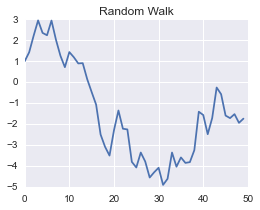

In [129]:
price_init = 1.0
p = [price_init]
gamma = 1.0 #making this 1.0 make p Random Walk
duration = 50

for i in range(1,duration):
    p.append(gamma*p[i-1] + np.random.normal(loc=0.0, scale=1.0, size=None))

plt.figure(1, figsize=(4,3))
plt.subplot(111)
plt.title('Random Walk')
plt.plot(p)
#plt.ylim([-7,7])

The drunk man's move ($\Delta p_t$) is influenced by previous position ($ (\gamma -1) p_{t-1}$) plus some fluctuation ($\epsilon_t$).

We can also add 'drift':
$$ \Delta p_t = \alpha + (\gamma -1) p_{t-1} + \epsilon_t $$ 
And 'trend':
$$ \Delta p_t = \alpha + \beta t + (\gamma - 1) p_{t-1} + \epsilon_t $$ 

If $\gamma = 1$, then this model becomes Random Walk, unpredictable.  For preditable $p_t$, we use Dickey-Fuller(DF) test to examines if $\gamma \neq 1$ (no unit root) so that $p_t$ is stationary. (There are several versions of DF test).

(-5, 120)

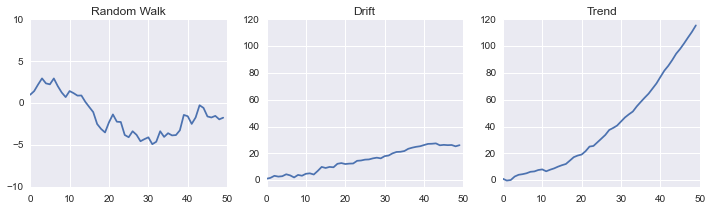

In [131]:
p_drift = [price_init]
drift = 0.7

for i in range(1,duration):
    p_drift.append(drift + gamma*p_drift[i-1] + np.random.normal(loc=0.0, scale=1.0, size=None))

p_trend = [price_init]
trend = 0.09

for i in range(1,duration):
    p_trend.append(trend*i + gamma*p_trend[i-1] + np.random.normal(loc=0.0, scale=1.0, size=None))
    
plt.figure(1, figsize=(12,3))

plt.subplot(131)
plt.title('Random Walk')
plt.plot(p)
plt.ylim([-10, 10])

plt.subplot(132)
plt.title('Drift')
plt.plot(p_drift)
plt.ylim([-5, 120])

plt.subplot(133)
plt.title('Trend')
plt.plot(p_trend)
plt.ylim([-5, 120])

To sum up: our candidate model for mean-reversion process in discrete time is DMW model. And we typically use DF test to show it is stationary.

Q: If we use stationarity to describe a mean-reverting process, why not just use stationarity instead of discussing mean-reversion.

Partial A : consider the following example:

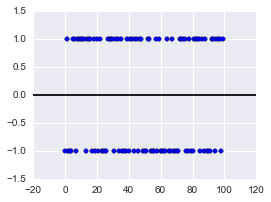

In [132]:
# we set length 100 but imagine the list is very long 
stationary_useless = [np.random.choice([1,-1]) for i in range(100)]

plt.figure(1, figsize=(4,3))
plt.subplot(111)
plt.scatter(range(len(stationary_useless)), stationary_useless)
plt.axhline(y=0, color='k')

Observe that this time seires randomly fluctuating -1 or 1, is useless for trading.
However, it is stationary with mean zero. This is an example of perculiarity of discrete process.

Mean-reverion is an intuitive concept:'pull toward a mean.' It is an ideal property in trading but intractable unlike stationary process. So in DMW model, we use stationarity to describe mean-reversion propery of data. This is one of resons people often conflate mean-reversion with stationarity, even though stationarity itself is not enough as the above example shows.

### Cointegration: tied drunk men

We imagine two drunk tied together walking. Their walks may be random, but since they are tied, they stay within a distance.

We define cointegration: $x_t, y_t$ are cointegrated if $d_t = y_t - b x_t$ is mean-reverting for some $b$. 

As we observed before, we use DF test to show $d_t$ is stationary to find if $x_t, y_t$ are cointegrated.
This is also called CADF test.

## 2. Model  Implementation and Improvement

A pair trading strategy implementation has obvisous two steps:
- find a cointegrated pair: $x_t, y_t$ with mean-reverting spread
- optimize statistical testing of spread to determine entry/exit points

The second step is not specific to pair trading. So we contemplate three possible routes (A-C) improving the 1st step. 

### A. Understanding Nature of Financial Data

If $x_t$ is the price of an equity, it is very likely that $x_t$ is not stationary. But common assumption is that return (or log price return) $\nabla x_t = x_t - x_{t-1}$ is stationary. In shorthand notation, we write $x_t$ is $I(1)$ and $\nabla x_t$ is $I(0)$. Different models are appropriate for different financial data.  

Instead of choosing a pair $x_t, y_t$ just by CADF for example, choose a pair where we understand the nature of relation between $x_t$ and $y_t$.    

### B. Improving CADF

There must be a room to improve DMW model and DF test.
For example in Orstein-Uhlenbeck model:
$$ d p_t = k(\mu - p_t) dt + \sigma dW_t $$
Here $k$ reprsents how fast $p_t$ pulls toward the mean.
This information can be useful determining entry/exit points.

### C. Cointegration among multiple time series

Cointegration can be generalized to multiple time series instead of just two.
Therefore we can devise a portfolio allocation model based on cointegraion among multiples equities, instead of a pair. This may improve stability of cointegratedness.